## NLP Workshop- CLL - Non semantic Vectorization & Embeddings

Authored by [@abhilash1910](https://www.kaggle.com/abhilash1910)

This is an extension of the [original Notebook](https://www.kaggle.com/colearninglounge/nlp-end-to-end-cll-nlp-workshop) which has been separately provided for a piecewise analysis of the Non semantic embedding and Vectorization Part. For more details other kernels are also provided:

- [Kernel](https://www.kaggle.com/colearninglounge/nlp-end-to-end-cll-nlp-workshop)
- [Kernel](https://www.kaggle.com/abhilash1910/nlp-workshop-ml-india)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_df=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
train_df.head()

In [ ]:
import pandas as pd
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


## Vectorization and Embeddings

In this context, we will be vectorizing our dataset. This would allow us to convert our data to higher dimensional containers (matrices). These vectorization strategies allow the word corpus to be properly suitable for advanced semantic analysis.

Here there are 2 variants of transforming the textual corpus to a numerical vector:

- Vectorize without semantics
- Retain Semantic Importance


In the first case, vectorization strategy is used to provide a co-occurence probabilistic distribution for vectorization. Methods like TF-IDF,Count vectorization/One hot vectorization, falls under this criteria.These methods leverage statistical co-occurence probabilities and log likelihoods for determining the frequently occuring sentences or group of words in a corpus.

The second case, relies on applying vectors with respect to semantic importance. Embeddings fall under this category. Embeddings are largely of 2 kinds

- Static Embeddings: Word2Vec, Glove, Fasttext, Paragram
- Dynamic Embeddings: ELMO, BERT & its variants, XLNet/Transformer-XL


All of these embeddings rely on pretrained word vectors where a probabilistic score is attributed to each word in the corpus. These probabilities are plotted in a low dimensional plane and the "meaning" of the words are inferred from these vectors. Generally speaking cosine distance is taken as the major metric of similarity measurement between word and sentence vectors to infer similarity.

## Vectorization - TFIDF and Count


We will move ahead with TFIDF and Count vectorization strategies and will be going in further sections.

- [TF-IDF Vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part. The formulation can be shown as follows:

<img src="https://plumbr.io/app/uploads/2016/06/tf-idf.png">


-[Count Vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.
A pictorial representation about the way in which vectorization occurs is provided:

<img src="https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0408.png">

Let us now go ahead and vectorize the corpus and test its dimensionality.

In [ ]:
%%time
tfidf_vect=TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf=tfidf_vect.fit_transform(train_df['review'].values.tolist())
train_tfidf.shape

In [ ]:
## Outputs from the TF-IDF transformed data
print(train_tfidf)

## Converting the labels to Binary Numerics

Here we convert the labels into binary (1,0) values , which will be helpful when we apply tensor compression or dimensionality reduction algorithms for visualizing the vectors.

In [ ]:
%%time
train_li=[]
for i in range(len(train_df)):
    if (train_df['sentiment'][i]=='positive'):
        train_li.append(1)
    else:
        train_li.append(0)
train_df['Binary']=train_li
train_df.head()

## Visualizing the Vector Space


As words and sentences are vectorized, the dimensions of the vector space becomes significantly large to be accomodated in a model. For any computation system it is recommended to keep the dimensions of a tensor (matrix) as small as possible and maintain its regularity. For tensors with larger dimensions and irregular shapes, it is difficult for the system to perform any operation (matrix /tensor multiplication etc.). Complex operations like tensor differentiation (Jacobian) or numerical approximation is another difficult thing to do for large matrices. The rank plays an important aspect for these operations.

Now, we have to reduce the dimensions ,else the kernel will run out of memory. For this we wmploy 3 different decomposition techniques:

- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


These algorithms rely on Eigen vector decomposition and Eigen matrices for creating smaller matrices. These reduced matrices are well-fitted to perform any numerical approximation tasks from differentiation to higher order non linear dynamics. [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) in general is a well known method and forms the base of all decomposition techniques. Pictorially it operates as follows with the help of orthogonal Eigen vectors


<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_ica_vs_pca_thumb.png">


TSNE is a more sophisticated [method](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) which uses a non convex optimization along with gradient descent. This is different than Eigen Vector (convex optimization) method of PCA and hence different results may be obtained in different iterations. It is a memory intensive method and is often powerful at the expense of longer execution time.

<img src="https://miro.medium.com/max/685/1*njEd7PiqBW-zW38E23Ho9w.png">




In [ ]:
#Count Vectorization
import matplotlib
import matplotlib.pyplot as plt
def vectorize(data):
    cv=CountVectorizer()
    fit_data_cv=cv.fit_transform(data)
    return fit_data_cv,cv


def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()

#Tfidf vectorization from sklearn
def tfidf(data):
    tfidfv=TfidfVectorizer()
    fit_data_tfidf=tfidfv.fit_transform(data)
    return fit_data_cv,tfidfv

def dimen_reduc_plot(test_data,test_label,option):
    tsvd= TruncatedSVD(n_components=2,algorithm="randomized",random_state=42)
    tsne=TSNE(n_components=2,random_state=42) #not recommended instead use PCA
    pca=SparsePCA(n_components=2,random_state=42)
    if(option==1):
        tsvd_result=tsvd.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        
        sns.scatterplot(x=tsvd_result[:,0],y=tsvd_result[:,1],hue=test_label        )
        
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(tsvd_result[:,0],tsvd_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negative Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
        plt.legend(handles=[color_orange,color_red])
        plt.title("TSVD")
        plt.show()
    if(option==2):
        tsne_result=tsne.fit_transform(test_data)
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        sns.scatterplot(x=tsne_result[:,0],y=tsne_result[:,1],hue=test_label)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(x=tsne_result[:,0],y=tsne_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negative Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
        plt.legend(handles=[color_orange,color_red])
        plt.title("PCA")
        plt.show() 
    if(option==3):
        pca_result=pca.fit_transform(test_data.toarray())
        plt.figure(figsize=(10,8))
        colors=['orange','red']
        sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],hue=test_label)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.scatter(x=pca_result[:,0],y=pca_result[:,1],c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        color_red=mpatches.Patch(color='red',label='Negtive Review')
        color_orange=mpatches.Patch(color='orange',label='Positive Review')
        plt.legend(handles=[color_orange,color_red])
        plt.title("TSNE")
        plt.show()
train_data=train_df
count_good=train_df[train_df['sentiment']=='positive']
count_bad=train_df[train_df['sentiment']=='negative']
plot_counts(len(count_good),len(count_bad))
data_vect=train_data['review'].values
data_vect_good=count_good['review'].values
target_vect=train_data['Binary'].values
target_data_vect_good=train_df[train_df['sentiment']=='positive']['Binary'].values
data_vect_bad=count_bad['review'].values
target_data_vect_bad=train_df[train_df['sentiment']=='positive']['Binary'].values
train_data_cv,cv= vectorize(data_vect)
real_review_train_data_cv,cv=vectorize(data_vect_good)

print(train_data.head())
dimen_reduc_plot(train_data_cv,target_vect,1)
dimen_reduc_plot(real_review_train_data_cv,target_data_vect_good,1)
dimen_reduc_plot(real_review_train_data_cv,target_data_vect_bad,1)
# dimen_reduc_plot(train_data_cv,target_vect,3)
# dimen_reduc_plot(real_review_train_data_cv,target_data_vect_good,3)
# dimen_reduc_plot(train_data_cv,target_vect,2)
# dimen_reduc_plot(real_review_train_data_cv,target_data_vect_good,2)

## Why Reduction?


Contextual word vectors are very large and they are determined with respect to the surrounding context.Visualizing large dimension tensors or vectors are computatinally very difficult. By lowering the dimension, the implication is that there is a tensor decomposition based on the above mentioned algorithms. Tensor decomposition is based on rank specifications of a tensor or matrix. Based on rank, these reductions rely on reducing the effective rank based on the number of components we would want to visualize. When we specify the number of components we would want the tensor to be compressed into, the effective rank reduction takes place by Eigen vector decomposition (which is a numerical method).

The TSNE, being a gradient descent based algorithm, takes up a lot of computation space when tried with large amounts of data. This leads to exhaustive memory consumption.In this case, a better solution would be to batch process the data, before passing it to the TSNE compressor. Tensorflow provides Projector which is really helpful for visualizing different embedding vectors which we will be going into. A visualization of the same is provided:

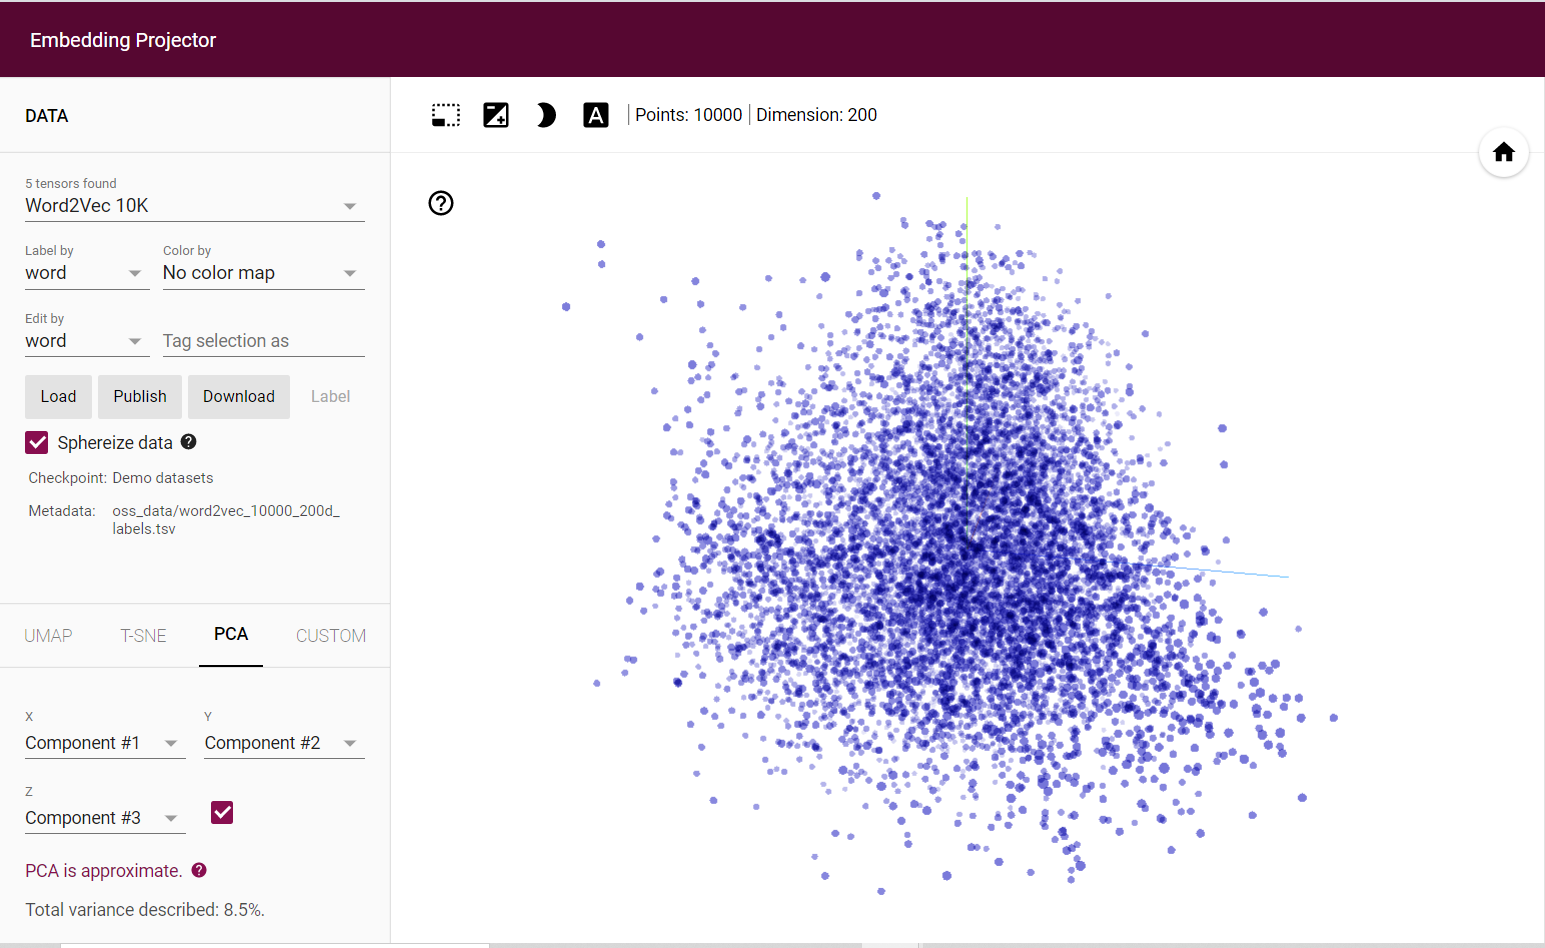

## Important Links for Reduction

These are some important links for the reduction strategies:

- [TSNE](https://www.datacamp.com/community/tutorials/introduction-t-sne)
- [Dimension Reduction](https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/#:~:text=Dimensionality%20reduction%20refers%20to%20techniques,input%20variables%20in%20a%20dataset.&text=Large%20numbers%20of%20input%20features,the%20number%20of%20input%20features.)
- [PCA & TSNE-Good article](https://medium.com/analytics-vidhya/a-complete-guide-on-dimensionality-reduction-62d9698013d2)
- [TFIDF and Reduction](https://towardsdatascience.com/2-latent-methods-for-dimension-reduction-and-topic-modeling-20ff6d7d547)
- [Berkely Course Advanced](https://people.eecs.berkeley.edu/~jordan/courses/294-fall09/lectures/dimensionality/)
- [SVD](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/)
- [U-V matrix decomposition- SVD](https://blog.statsbot.co/singular-value-decomposition-tutorial-52c695315254)


In [ ]:
#TSNE visualization on first 1000 samples
train_data=train_df[:1000]       
data_vect=train_data['review'].values
data_vect_good=count_good['review'].values
target_vect=train_data['Binary'].values
target_data_vect_good=train_df[train_df['sentiment']=='positive']['Binary'].values
data_vect_bad=count_bad['review'].values
target_data_vect_bad=train_df[train_df['sentiment']=='positive']['Binary'].values
train_data_cv,cv= vectorize(data_vect)
real_review_train_data_cv,cv=vectorize(data_vect_good)
dimen_reduc_plot(train_data_cv,target_vect,3)

## Convert Input DataFrame to a List

This phase is helpful if we would like to investigate individual word embeddings or sentence embeddings. Differentiating the individual rows of text makes it easier to pass into static and dynamic embedding models.

In [ ]:
check_df=list(train_df['review'].str.split())

## Conclusion of Non semantic Embeddings

In the next sections, we will be looking into Static Semantic Embeddings and visualizing [them](https://www.kaggle.com/colearninglounge/nlp-end-to-end-cll-nlp-workshop#Semantic-Embeddings).